In [1]:
import pandas as pd
import json

In [2]:
df = pd.DataFrame(columns=['Play','Act','Scene','Character','Line'])

In [3]:
data = None
with open('output/shakespeare_acts_scenes.json') as f:
    data = json.load(f)

In [4]:
for play_name,play_content in data.items():
    for acts,scenes in play_content.items():
        for scene,lines in scenes.items():
            for line in lines:
                if len(line)>1:
                    df = df.append({'Play':play_name.title(), 'Act':acts, 'Scene':scene, 'Character':line[0].title(), 'Line':line[1]}, ignore_index=True)

In [5]:
df['Line_chars'] = df.apply(lambda x: len(x['Line']), axis=1)

In [6]:
df.drop(df[df['Line_chars']==1].index, inplace=True) # remove lines of only one char; only two such instances

In [7]:
import spacy
import en_core_web_lg

from spacy.tokenizer import Tokenizer

In [8]:
nlp = en_core_web_lg.load()
tokenizer = Tokenizer(nlp.vocab)

In [9]:
df['Line_spacy'] = df.apply(lambda x: (len(tokenizer(x['Line'])),tokenizer(x['Line'])), axis=1)
df[['Line_spacy_len','Line_spacy']] = df['Line_spacy'].to_list()

/home/bryan/Documents/Code/python-environments/SHAKESPEAREAN_NETWORKS/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
df.head()

,Play,Act,Scene,Character,Line,Line_chars,Line_spacy,Line_spacy_len
0,Romeo,ACT I,SCENE I,Sampson,"Gregory, on my word, we’ll not carry coals.",43,"(Gregory,, on, my, word,, we’ll, not, carry, c...",8
1,Romeo,ACT I,SCENE I,Gregory,"No, for then we should be colliers.",35,"(No,, for, then, we, should, be, colliers.)",7
2,Romeo,ACT I,SCENE I,Sampson,"I mean, if we be in choler, we’ll draw.",39,"(I, mean,, if, we, be, in, choler,, we’ll, draw.)",9
3,Romeo,ACT I,SCENE I,Gregory,"Ay, while you live, draw your neck out o’ the ...",53,"(Ay,, while, you, live,, draw, your, neck, out...",11
4,Romeo,ACT I,SCENE I,Sampson,"I strike quickly, being moved.",30,"(I, strike, quickly,, being, moved.)",5


# Create overall networks

In [16]:
import networkx as nx

In [41]:
all_plays = []

In [42]:
for play in df['Play'].unique():
    G = nx.Graph(name=play)
    temp_df = df[df['Play']==play]
    for i in range(len(temp_df.index)):
        try:
            if G.has_edge(temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character']):
                G.edges()[temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character']]['weight']+=1
            else:
                G.add_edge(temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character'], weight=1)
        except:
            pass
    all_plays.append(G)

In [45]:
for i in all_plays:
    print(nx.info(i),'\n')

Name: Romeo
Type: Graph
Number of nodes: 31
Number of edges: 86
Average degree:   5.5484 

Name: Othello
Type: Graph
Number of nodes: 25
Number of edges: 69
Average degree:   5.5200 

Name: Hamlet
Type: Graph
Number of nodes: 36
Number of edges: 74
Average degree:   4.1111 

Name: Caesar
Type: Graph
Number of nodes: 47
Number of edges: 124
Average degree:   5.2766 

Name: Macbeth
Type: Graph
Number of nodes: 39
Number of edges: 103
Average degree:   5.2821 

Name: Midsummer
Type: Graph
Number of nodes: 34
Number of edges: 88
Average degree:   5.1765 



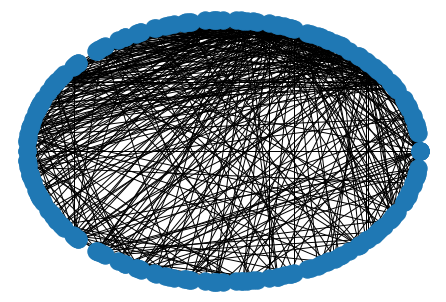

In [46]:
for i in all_plays:
    nx.draw_circular(i)

# END